# Ayudantia 11: precondicionadores para FEM

# 1. FEM con solución conocida y gráfico de la solución.

Resolvemos el problema:

$$
-\Delta u = f, \quad \text{en } \Omega = (0, 1)\times (0, 1)\\
u = 0, \quad \text{sobre } \partial \Omega
$$

con una discretización de elementos finitos con funciones continuas y lineales 
a trozos. Primero, discretizamos el dominio con triángulos de la siguiente 
forma:

C:\Users\sfsta\AppData\Local\Temp\ipykernel_27980\1550536716.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


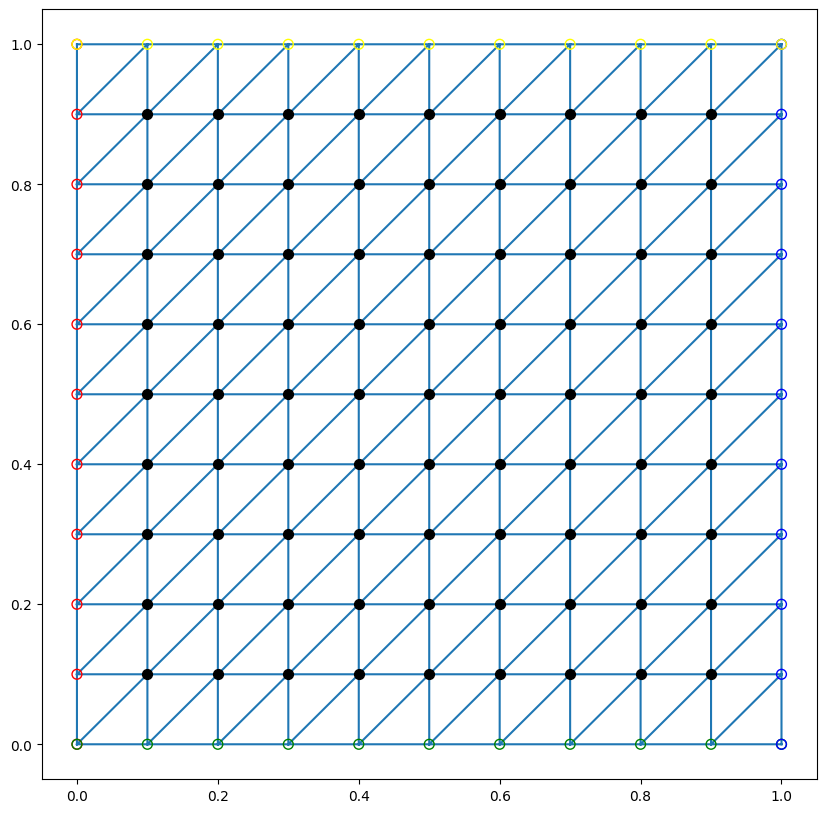

In [1]:
%matplotlib inline
import numpy as np
from vmesh import from_coords

"""
Allowed element types:
- crisscross
- unionjack
- triangle_left
- triangle_right
- rectangle
"""

coords = (0, 1, 0, 1)
ndx, ndy = 10, 10
mesh = from_coords(ndx, ndy, coords, el_type="triangle_right")
fig, ax = mesh.plot_mesh(fp=500)
fig.show()

Continuamos instanciando el modelo y generando la solución. Utilizamos 

$$
f(x, y) = 2\pi^2\sin(\pi x)\sin(\pi y)
$$

De esta forma la solución es conocida $u(x, y) = \sin(\pi x)\sin(\pi y)$

In [2]:
from meshio import write_points_cells

def save_plot(path, mesh, u):
    el_dict = {}
    for key in mesh.IEN.keys():
        if key == "rectangle":
            el_dict["quad"] = mesh.IEN["rectangle"]
        elif key in mesh.triangle_el_types:
            if "triangle" in el_dict.keys():
                nIEN = np.concatenate(
                    (el_dict["triangle"], mesh.IEN[key]), 
                    axis=0
                )
                el_dict["triangle"] = nIEN
            else:
                el_dict["triangle"] = mesh.IEN[key]
    write_points_cells(f"{path}.vtk", mesh.xyz, el_dict, {"disp": u})

In [3]:
import numpy as np
from problems import PoissonProblem
from solvers import LinearFEMSolver
import scipy.sparse.linalg as spsl

# problem generation
ndx, ndy = 100, 100
coords = (0, 1, 0, 1)
f = lambda x, y: (2*np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
problem = PoissonProblem(f=f, k=0, coords=coords)
mesh = from_coords(ndx, ndy, coords)
solver = LinearFEMSolver(problem, mesh)

# mass and stifness matrices
M, S, b = solver.model()
m, n = S.shape
x = spsl.spsolve(M-S, b)
x = solver.extended_sol(x)
save_plot("poisson_sol_exact", mesh, x)

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

# Precondicionadores

Veremos cómo se comportan los métodos de Gradientes Conjugados y GMRES 
precondicionados. Recordar que para precondicionar Gradientes Conjugados, el 
precondicionador también debe ser simétrico y definido positivo. Primero, para 
el caso de CG implementamos directamente el algoritmo precondicionado.

In [ ]:
def PCG(A, M_inv, b, x0, j_max=1000, tol=1e-10):
    """
    Implementation of preconditioned conjugate gradients.
    """

    m, n = A.shape
    j = 0
    rj = (b - A@x0).T
    rjm = (b - A@x0).T
    xj = x0
    zj = M_inv(rj)
    zjm = zj
    errs = [np.linalg.norm(rj)]
    while (np.linalg.norm(rj) > tol) and (j < j_max):
        j += 1
        if j==1:
            pj = zj
        else:
            tau = float((rj.T.dot(zj))/(rjm.T.dot(zjm)))
            pj = zj + tau*pj
        mu = float((rj.T.dot(zj))/(pj.T.dot((A @ pj))))
        xj = xj - mu*pj.flatten()
        rjm = rj.copy()
        rj = rj - mu*A@pj
        zjm = zj.copy()
        zj = M_inv(rj)
        errs.append(np.linalg.norm(rj))
    return xj, errs

In [5]:
import scipy.sparse.linalg as spsl
import scipy.sparse as sps

def Jacobi_pre(A):
    D = A.diagonal()
    def M_inv(x):
        return (1/D)*x
    return M_inv

def null_pre(A):
    def M_inv(x):
        return x
    return M_inv

def SSOR(A, w):
    L = sps.diags(A.diagonal()) + w*sps.tril(A, k=-1)
    D = A.diagonal()
    def M_inv(x):
        x = spsl.spsolve_triangular(L, x)
        x = D*x
        x = spsl.spsolve_triangular(L.transpose(), x, lower=False)
        return x
    return M_inv

## Precondicionadores para el problema 1

Primero comparamos los precondicionadores para el problema 1.

C:\Users\sfsta\AppData\Local\Temp\ipykernel_27980\3764979131.py:21: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  x = spsl.spsolve_triangular(L.transpose(), x, lower=False)


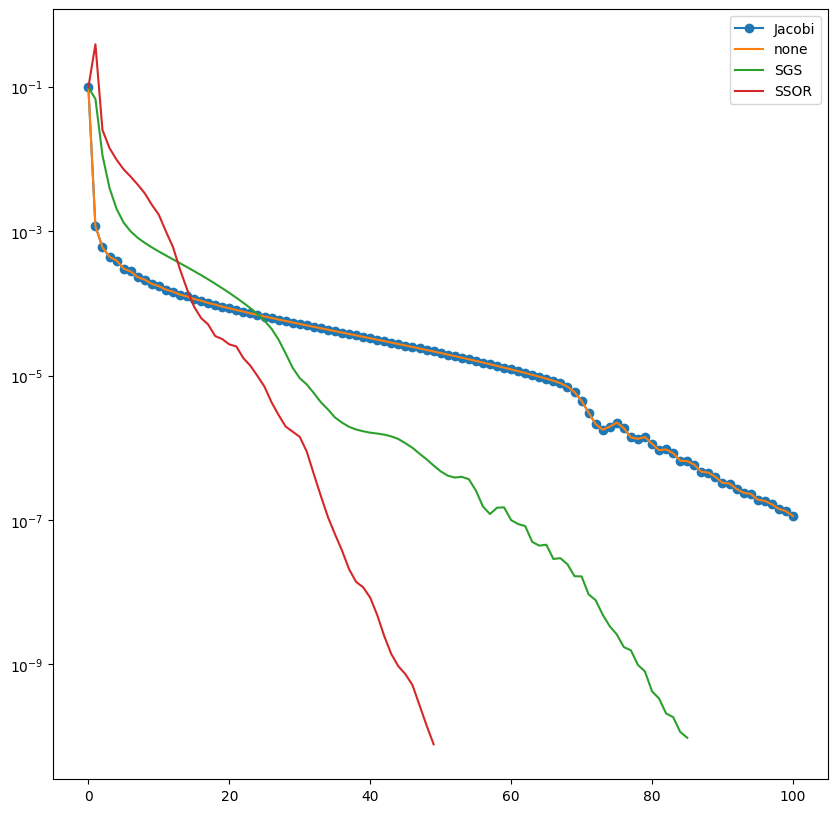

In [6]:
import numpy as np
import scipy.sparse.linalg as spsl
from problems import PoissonProblem
from vmesh import from_coords
from solvers import LinearFEMSolver

# problem generation
ndx, ndy = 100, 100
coords = (0, 1, 0, 1)
f = lambda x, y: (2*np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
problem = PoissonProblem(f=f, k=0, coords=coords)
mesh = from_coords(ndx, ndy, coords)
solver = LinearFEMSolver(problem, mesh)

# mass and stifness matrices
M, S, b = solver.model()
m, n = S.shape

A = -M+S
b = -b
M_inv = Jacobi_pre(A)
x0 = np.zeros(n)
sol, errsJ = PCG(A, M_inv, b, x0, j_max=100)
sol, errsSSOR = PCG(A, SSOR(A, w=1.65), b, x0, j_max=100)
sol, errsSGS = PCG(A, SSOR(A, w=1), b, x0, j_max=100)
sol, errs = PCG(A, null_pre(A), b, x0, j_max=100)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(errsJ, label="Jacobi", marker="o")
ax.plot(errs, label="none")
ax.plot(errsSGS, label="SGS")
ax.plot(errsSSOR, label="SSOR")

ax.set_yscale("log")
ax.legend()

Realizamos el siguiente experimento: para una tolerancia fija, medimos el 
número de iteraciones necesarias para alcanzar esa tolerancia, para distintos
valores de n

In [7]:
import numpy as np
import scipy.sparse.linalg as spsl
from problems import PoissonProblem
from vmesh import from_coords
from solvers import LinearFEMSolver
from tqdm import tqdm

NN = [5*i for i in range(1, 40)]
tol = 1e-5
niters_none = []
niters_jacobi = []
niters_sgs = []
niters_ssor = []

for n in tqdm(NN):
    # problem generation
    ndx, ndy = n, n
    coords = (0, 1, 0, 1)
    f = lambda x, y: (2*np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
    problem = PoissonProblem(f=f, k=0, coords=coords)
    mesh = from_coords(ndx, ndy, coords)
    solver = LinearFEMSolver(problem, mesh)

    # mass and stifness matrices
    M, S, b = solver.model()
    m, n = S.shape

    A = -M+S
    b = -b
    M_inv = Jacobi_pre(A)
    x0 = np.zeros(n)
    sol, errsJ = PCG(A, M_inv, b, x0, tol=tol)
    sol, errsSSOR = PCG(A, SSOR(A, w=1.5), b, x0, tol=tol)
    sol, errs = PCG(A, null_pre(A), b, x0, tol=tol)
    sol, errsSGS = PCG(A, SSOR(A, w=1), b, x0, tol=tol)
    niters_none.append(len(errs))
    niters_jacobi.append(len(errsJ))
    niters_ssor.append(len(errsSSOR))
    niters_sgs.append(len(errsSGS))

  0%|          | 0/39 [00:00<?, ?it/s]C:\Users\sfsta\AppData\Local\Temp\ipykernel_27980\3764979131.py:21: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  x = spsl.spsolve_triangular(L.transpose(), x, lower=False)
100%|██████████| 39/39 [31:28<00:00, 48.44s/it] 


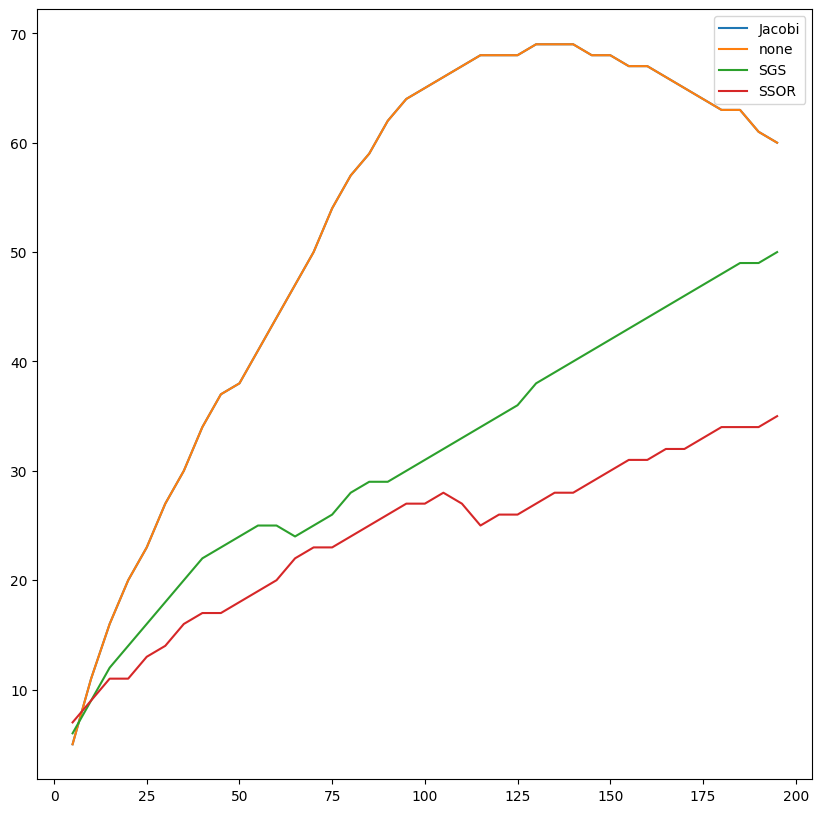

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(NN, niters_jacobi, label="Jacobi")
ax.plot(NN, niters_none, label="none")
ax.plot(NN, niters_sgs, label="SGS")
ax.plot(NN, niters_ssor, label="SSOR")

ax.legend()

Si queremos utilizar las funciones de scipy, podemos utilizar la clase 
LinearOperator de scipy.sparse.linalg para definir precondicionadores.

In [9]:
from scipy.sparse.linalg import LinearOperator

class gmres_counter:
    
    """
    Créditos al buen Giovanni Frison que me ayudó a ver como 
    guardar la norma residual en cada iteración de gmres
    https://stackoverflow.com/questions/42228416/gmres-residual-plotting
    """
    
    def __init__(self, disp=True):
        self.niter = 0
        self.callbacks = [1]
        self._disp = disp
        
    
    def __call__(self, value):
        self.niter += 1
        self.callbacks.append(value)
        if self._disp:
            print(value)

class SGSPrecond(LinearOperator):

    def __init__(self, A):
        D = A.diagonal()
        self.D = sps.diags(D)
        self.Dm1 = sps.diags(1/D)
        self.E = -sps.tril(A, k=-1)
        self.F = -sps.triu(A, k=1)

    def _matvec(self, x):
        I = sps.eye(self.D.shape[0])
        z = spsl.spsolve_triangular(I-self.E.dot(self.Dm1), x, lower=True)
        w = spsl.spsolve_triangular(self.D - self.F, z, lower=False)
        return w

    @property
    def shape(self):
        return self.D.shape

    @property
    def dtype(self):
        return self.D.dtype

In [10]:
import numpy as np
import scipy.sparse.linalg as spsl
from problems import PoissonProblem
from vmesh import from_coords
from solvers import LinearFEMSolver

# problem generation
ndx, ndy = 100, 100
coords = (0, 1, 0, 1)
f = lambda x, y: (2*np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y)
problem = PoissonProblem(f=f, k=0, coords=coords)
mesh = from_coords(ndx, ndy, coords)
solver = LinearFEMSolver(problem, mesh)

# mass and stifness matrices
M, S, b = solver.model()
m, n = S.shape

A = M-S
counter = gmres_counter(disp=False)
counterSGS = gmres_counter(disp=False)

x, errs = spsl.gmres(A, b, callback=counter, callback_type="pr_norm")
x, errsSGS = spsl.gmres(A, b, M=SGSPrecond(A), callback=counterSGS, callback_type="pr_norm")

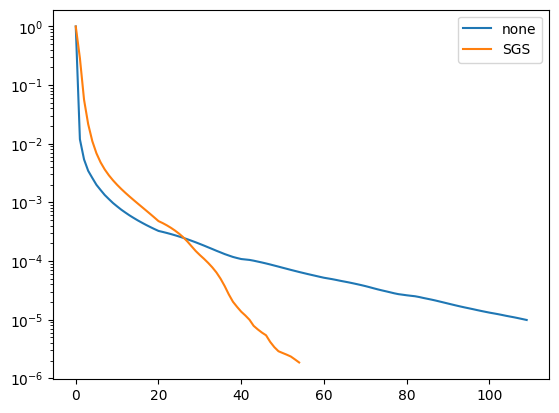

In [11]:
import matplotlib.pyplot as plt

# plt.plot(errsJ, label="Jacobi")
plt.plot(counter.callbacks, label="none")
plt.plot(counterSGS.callbacks, label="SGS")
plt.yscale("log")
plt.legend()